In [45]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import toml
import os
import sys
sys.path.append("../")

import models
import datasets

%matplotlib inline


In [46]:
config = r'../saved/147319_m1/2022-12-11-12-50-40/log/147319.toml'  # Just modify this path!
with open(config, 'r', encoding='utf8') as f:
    info = toml.load(f)
 

In [47]:
       
model_path = f"../saved/{info['name']}/"
model_path = model_path + sorted(os.listdir(model_path))[-1] + "/model/model_best.pth"
model_path
    

'../saved/147319_m1/2022-12-11-12-50-40/model/model_best.pth'

In [48]:
def get_object(module, s: str, parameter: dict):
        return getattr(module, s)(**parameter)
    
# on src domain
dataset_valid = get_object(datasets, info['dataloader_valid']['dataset']['name'], 
                           info['dataloader_valid']['dataset']['args'])
dataloader_valid = torch.utils.data.DataLoader(dataset=dataset_valid, **info['dataloader_valid']['args'])
# on tgt domain
dataset_test = get_object(datasets, info['dataloader_test']['dataset']['name'], 
                          info['dataloader_test']['dataset']['args'])
dataloader_test = torch.utils.data.DataLoader(dataset=dataset_test, **info['dataloader_test']['args'])

Successfully loaded dataset on Rx of ['14-7'], with shape of torch.Size([4800, 2, 256]), torch.Size([4800])
Successfully loaded dataset on Rx of ['3-19'], with shape of torch.Size([4800, 2, 256]), torch.Size([4800])


In [49]:
checkpoint = torch.load(model_path)
state_dict = checkpoint['state_dict']

In [50]:
model_resumed = get_object(models, info['model']['name'], info['model']['args'])
model_resumed.load_state_dict(state_dict)
model_resumed = model_resumed.cuda()

In [51]:
loader1 = dataloader_valid
loader2 = dataloader_test


In [52]:
def plot_scatters(data, labels, mode="label_clusters", fig_name="fig"):
    """
    colormaps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
    """
    fig, ax = plt.subplots(figsize=(8, 7))
    if mode == "label_clusters":
        # viridis, tab10, 
        scatters = ax.scatter(data[:, 0], data[:, 1], c=labels, alpha=0.5, cmap='viridis')
        fig.colorbar(scatters)
    elif mode == "domain_clusters":
        # Paired, 
        scatters = ax.scatter(data[:, 0], data[:, 1], c=labels, alpha=0.7, cmap='Paired')
        legends = ax.legend(*scatters.legend_elements(), loc="best", title="Receivers")
        ax.add_artist(legends)
        
    # ax.set_xlabel("z[0]")
    # ax.set_ylabel("z[1]")
    ax.set_xlim(-90, 90)
    ax.set_ylim(-90, 90)
    fig.savefig(f"../figs/{fig_name}.eps", format="eps", bbox_inches='tight', pad_inches=0, dpi=300)
    fig.show()
    

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9472 samples in 0.000s...
[t-SNE] Computed neighbors for 9472 samples in 1.494s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9472
[t-SNE] Computed conditional probabilities for sample 2000 / 9472
[t-SNE] Computed conditional probabilities for sample 3000 / 9472
[t-SNE] Computed conditional probabilities for sample 4000 / 9472
[t-SNE] Computed conditional probabilities for sample 5000 / 9472
[t-SNE] Computed conditional probabilities for sample 6000 / 9472
[t-SNE] Computed conditional probabilities for sample 7000 / 9472
[t-SNE] Computed conditional probabilities for sample 8000 / 9472
[t-SNE] Computed conditional probabilities for sample 9000 / 9472
[t-SNE] Computed conditional probabilities for sample 9472 / 9472
[t-SNE] Mean sigma: 0.205229


/home/rxy/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.014954
[t-SNE] KL divergence after 1000 iterations: 1.066691


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/tmp/ipykernel_3625613/3528747501.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


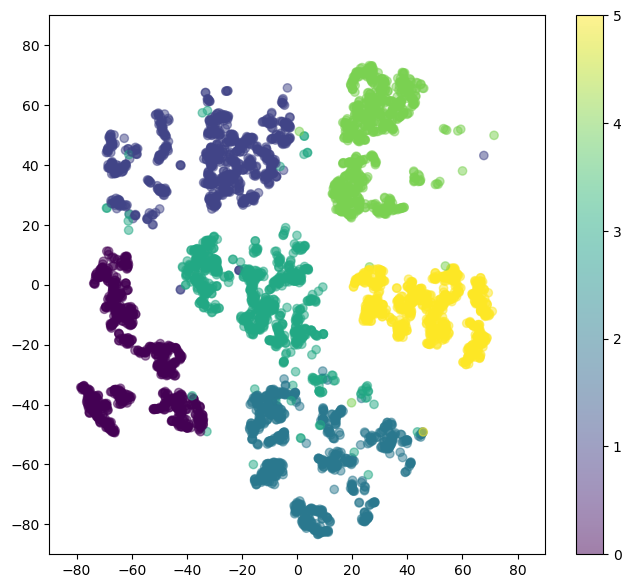

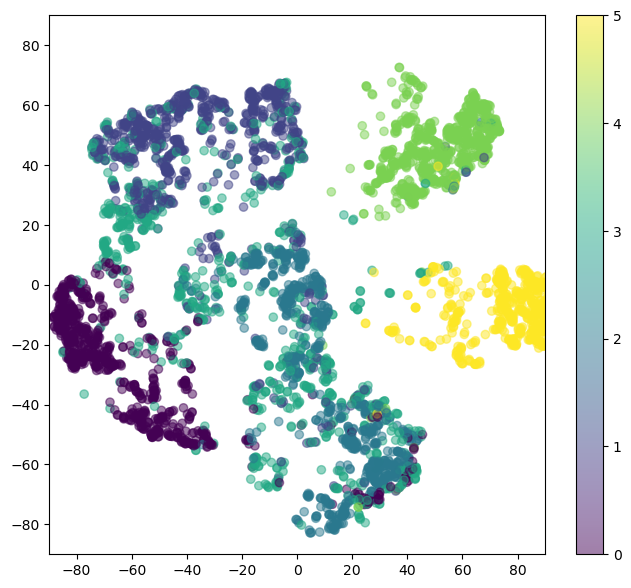

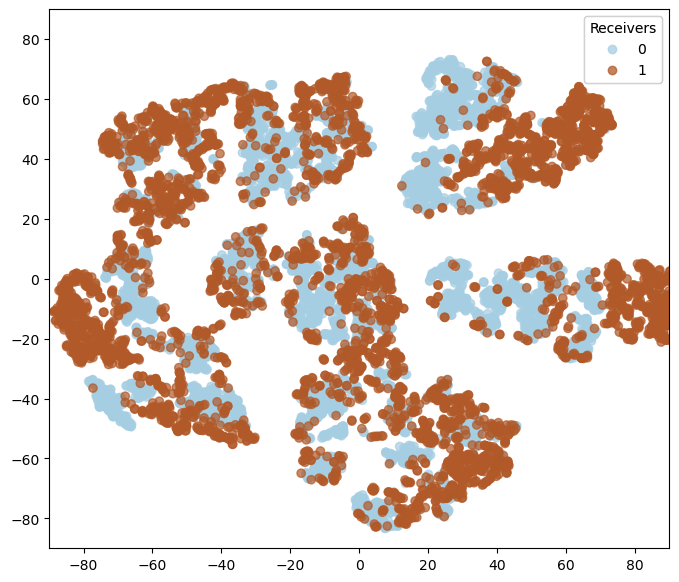

In [53]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

all_feats, all_targets = [], []
model_resumed.eval()
with torch.no_grad():
    if loader2 is None:
        for data1, targets1, *_ in loader1:
            _, feat1 = model_resumed(data1.cuda())
            all_feats.append(feat1.cpu().numpy())
            all_targets.append(targets1.numpy())

        z = np.concatenate(all_feats, axis=0)
        labels = np.concatenate(all_targets, axis=0)
        z = TSNE(2, init='pca', learning_rate='auto', verbose=1).fit_transform(z)

        plot_scatters(z, labels, mode="label_clusters", fig_name="tsne_src")
    else:
        # 1.1 loader1
        for data1, targets1, *_ in loader1:
            _, feat1 = model_resumed(data1.cuda())
            all_feats.append(feat1.cpu().numpy())
            all_targets.append(targets1.numpy())

        z = np.concatenate(all_feats, axis=0)
        labels = np.concatenate(all_targets, axis=0)
        # number of samples in loader1
        num1 = z.shape[0]  
        # 1.2 loader2
        for data2, targets2, *_ in loader2:
            _, feat2 = model_resumed(data2.cuda())
            all_feats.append(feat2.cpu().numpy())
            all_targets.append(targets2.numpy())
            
        z = np.concatenate(all_feats, axis=0)
        labels = np.concatenate(all_targets, axis=0)
        # 2. t-sne
        z = TSNE(2, init='pca', learning_rate='auto', verbose=1).fit_transform(z)
        
        # 3.1 plot label clusters of loader1 (src domain)
        plot_scatters(z[:num1], labels[:num1], mode="label_clusters", fig_name="tsne_src")
        # 3.2 plot label clusters of loader2 (tgt domain)
        plot_scatters(z[num1:], labels[num1:], mode="label_clusters", fig_name="tsne_tgt")
        # 3.3 plot domain clusters of loader1 (0) and loader2 (1)
        domain_labels = np.concatenate([np.zeros(num1), np.ones(z.shape[0]-num1)], axis=0)
        plot_scatters(z, domain_labels, mode="domain_clusters", fig_name="tsne_domain")
        

In [54]:
print(z.shape)
print(labels.shape)

(9472, 2)
(9472,)
